# Here I fit the Curie-Weiss Law to the Magnetization vs Temeperature data as measured by the PPMS-VSM. 
### Note that reading in mass and type of file is hardcoded to follow my lab's convention for file naming.

# We typically look at two types of runs, Field Cooling (FC) and Zero-Field Cooling (ZFC).
## If the Weiss constant is negative we have an antiferromagnet, if the Weiss constant is positive we have a ferromagnet.
## We get the effective magnetic moment and g-factor from Curie's constant

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model
import seaborn as sns
import pandas as pd
sns.set()

## My functions

In [124]:
# Takes a filename and data directory
# Returns the field, magnetic moment, error, and name (temperature) of the run
# field, moment, and error are returned as np arrays
# name is returned as a string
## Note that the name handling is hardcoded for how my lab conventionally names our files.
def getData(magrun, dataDir):
    name = magrun.split('_')[4].split('.')[0].replace('P','.')
    mass = getMass(magrun)
    measType = magrun.split('_')[5].split('.')[0]
    df = pd.read_csv(dataDir+magrun)
    df.dropna(inplace = True)
    T = np.array(df['Temperature (K)'])
    H = np.array(df['Magnetic Field (Oe)'])
    E = np.array(df['M. Std. Err. (emu)'])
    M = np.array(df['Moment (emu)'])
    return M,H,T,E, mass, name, measType

# Takes a filename
# Returns mass in grams
def getMass(filename):
    mass = filename.split('_')[2]
    mass = mass.replace('P','.')
    mass = mass[:-2]
    return float(mass)/1000

# This is the inverse of the Curie-Weiss Law.
# We will be creating an LMFIT model with this and fitting for:
## Curie's constant 'c', Weiss' constant 'wc'
def Curiei(t,c,wc):
    return(t-wc)/c

# Takes in Curie's constant and the system's total angular momentum J value
# Returns effective moment (bohr magnetons) and effective g-factor
def calcConstants(c,J):
    ueff = np.sqrt(8*c)
    gj = ueff/np.sqrt(J*(J+1))
    return ueff, gj

## Manually enter the sample name, molecular weight, and mass error (for our scales  .00005 g)
https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm


In [125]:
comp = 'ErOI'
molweight = 310.16
massE = .00005

## Load the M vs T data file names into a list and create a dictionary 'data' which holds all of the measured data for that type of measurement
### {'FC/ZFC' : [Magnetization, Applied Field, Temperature, Magnetization error, sammplemass,  ]}

In [126]:
dataDir = 'data/'
runs = []
for i in os.listdir(dataDir):
    if i.endswith('.DAT'):
        runs.append(i)

# Choose the Magnetization (M vs T) .dat file to analyze. 

Specify compound name, directory, and the run we're lookating at.

In [127]:
data = {}
for i in runs:
    M,H,T,Err,samplemass,name,measType = getData(i,dataDir)
    data[measType] = [M,H,T,Err,samplemass,name,measType]

M,H,T,Err,samplemass,name,measType = data['ZFC']

# Calculate the Susceptibility and Susceptibility Error (normalized to emu Oe^-1 Mol^-1)

In [128]:
SuscNorm = []
SuscErrorNorm = []
for i in range(len(M)):
    SuscNorm.append(M[i]/H[i]*molweight/samplemass/1)
    SuscErrorNorm.append(E[i]/H[i]*molweight/samplemass + M[i]/H[i]*molweight*massE/(samplemass**2))    

# Getting inverse susceptibility and inverse of the error

In [129]:
Xi = []
SuscErrorNormi = []

for i in SuscNorm:
    Xi.append(1/i)
Xi = np.array(Xi)

for i in range(len(SuscErrorNorm)):
    SuscErrorNormi.append(SuscErrorNorm[i]/SuscNorm[i]**2)
SuscErrorNormi = np.array(SuscErrorNormi)

# Choose a range of temperatures to fit over.  "tr"

# Make initial guess for "c" and "tc"

In [130]:
tr = [0,400] #temprange = [low,high]

cmodeli =  Model(Curiei, independent_vars = ['t'])
params = cmodeli.make_params()
params['wc'].set(value = 10)
params['c'].set(value = 10)


Fit Over Desired Range

In [131]:
newT = []
newXi = []
newE = []
for i in range(len(T)):
    if (T[i] >= tr[0] and T[i]<= tr[1]):
        newT.append(T[i])
        newXi.append(Xi[i])
        newE.append(SuscErrorNormi[i])


resulti = cmodeli.fit(newXi, params, t = newT, weights = newE) #fit

# We now plot everything: Measured 1/X and Fitted 1/X.

## Linear Linear

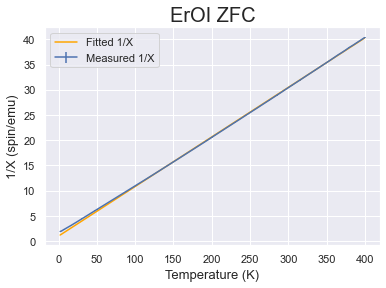

Susc error norm =  0.002826862613737191
The Weiss constant = -10.54 K
The Curie constant = 10.193
Effective moment for ErOI is 9.030 bohr ,  gj factor = 10.427


In [132]:
plt.errorbar(T,Xi,yerr = SuscErrorNormi, fmt ='-',label = 'Measured 1/X')
plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
plt.title(comp + " " + measType, fontsize = 20)
plt.xlabel('Temperature (K)', fontsize = 13)
plt.ylabel('1/X (spin/emu)', fontsize = 13)
plt.legend()
plt.show()


print('Susc error norm = ', SuscErrorNormi[0])
print('The Weiss constant = {:.2f} K\nThe Curie constant = {:.3f}'.format(resulti.params['wc'].value,resulti.params['c'].value))

ueff, gj = calcConstants(resulti.params['c'].value,1/2)

# print(ueff/(mass/molweight)*6.02*10**-23)
print('Effective moment for {:} is {:.3f} bohr ,  gj factor = {:.3f}'.format(comp,ueff,gj))

In [133]:
print('1/X fitted parameters')
resulti.result.params.pretty_print()
print('\n Reduced chi sqr: ', resulti.result.redchi)
print('\n Chi sqr: ', resulti.result.chisqr)

1/X fitted parameters
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
c      10.19     -inf      inf  0.01007     True     None     None
wc    -10.54     -inf      inf   0.3138     True     None     None

 Reduced chi sqr:  6.95107520370689e-06

 Chi sqr:  0.000820226874037413


## Log Linear

In [134]:

# plt.plot(T,Xi,'b.',alpha=.05,label = 'Measured 1/X')
# plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
# plt.title(comp, fontsize = 20)
# plt.xlabel('Temperature (K)', fontsize = 13)
# plt.ylabel('1/X', fontsize = 13)
# plt.yscale('log')
# plt.legend()
# plt.show()

## Log Log

In [135]:
# plt.plot(T,Xi,'b.',alpha=.05,label = 'Measured 1/X')
# plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
# plt.title(comp, fontsize = 20)
# plt.xlabel('Temperature (K)', fontsize = 13)
# plt.ylabel('1/X', fontsize = 13)
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.show()

# Print out fitted curie constant, weiss constant, chi sqr, reduced chi sqr, and magnetic moment.

In [136]:
# print('1/X fitted parameters:\n--------------------------------------------------------------------')
# resulti.params.pretty_print()
# print('\n\n--------------------------------------------------------------------')
# print(' Reduced chi sqr: ', resulti.redchi)
# print('Chi sqr: ', resulti.chisqr)
# print('--------------------------------------------------------------------\n\n')
# # print('Magnetic moment(not correct yet) = ',2.34*np.sqrt(resulti.params['c'].value))